Practical Work in AI - Concept Bootleneck Models<br>
Tragler Thomas <br>
====================<br>


In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import wandb
from datetime import datetime
import torch.optim as optim
from sklearn.model_selection import KFold

import derm7pt_data
from derm7pt_data import Derm7pt_data
from Model import Simple_CNN_Net, Simple_CNN_PerfectConcepts, Concept_To_Label_Net

from importlib import reload

In [2]:
reload(derm7pt_data)
#reload(Model)

#Data loading
random_state = 42
torch.manual_seed(random_state)
path = os.path.normpath('Data\\Derm7pt')

derm7pt = Derm7pt_data(path)
metadata = derm7pt.metadata
print("Data shape:", metadata.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("device:", device)

Data shape: (1011, 34)
device: cuda


In [3]:
metadata.columns

Index(['case_num', 'diagnosis', 'seven_point_score', 'pigment_network',
       'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules',
       'blue_whitish_veil', 'vascular_structures',
       'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex',
       'clinic', 'derm', 'diagnosis_num', 'is_cancer', 'abbrevs', 'info',
       'pigment_network_num', 'pigment_network_score', 'streaks_num',
       'streaks_score', 'pigmentation_num', 'pigmentation_score',
       'regression_structures_num', 'regression_structures_score',
       'dots_and_globules_num', 'dots_and_globules_score',
       'blue_whitish_veil_num', 'blue_whitish_veil_score',
       'vascular_structures_num', 'vascular_structures_score'],
      dtype='object')

In [4]:
#Help functions to calculate the majority class baseline    
def majority_class_baseline(val_idx, mode_txt=""):
    print("start ", mode_txt, " baseline: ", datetime.now())
    majority_loader = DataLoader(
        dataset=derm7pt,
        batch_size=999999,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )
    for i, batch in enumerate(majority_loader, 0):
        inputs, labels, concept_labels = batch
        baseline, simple_val_baseline = majority_class_accuracy_by_labels(labels)
        
        #concept baseline
        concept_baseline = 0
        concept_outputs = torch.zeros(len(labels), num_concepts)
        concept_val_baseline = ((concept_outputs == concept_labels).sum().item()) / (len(labels)*num_concepts)
        
        print("end ", mode_txt, " baseline:   ", datetime.now(), ", baseline: ", baseline, " percent ",  simple_val_baseline, " concept_baseline: ", concept_baseline, " concept_val_baseline: ", concept_val_baseline)
        return simple_val_baseline, concept_val_baseline
    
def majority_class_accuracy_by_labels(true_labels):
    # Find the most frequent class in the training set
    elems, counts = true_labels.unique(return_counts=True)
    majority_count = counts[counts.argmax()]
    majority_class = elems[counts.argmax()]
    #predictions = torch.full_like(true_labels, majority_class)
    accuracy = majority_count / len(true_labels)
    return majority_class, accuracy

In [5]:
#Training the model
# hyperparameters
n_epochs = 50
learning_rate = 0.0002
n_folds = 8
batch_size = 8
learn_concepts = True   #Defines if loss should be calculated for concepts

num_classes = derm7pt.diagnosis_mapping[derm7pt.model_columns["label"]].nunique()
num_concepts = len(derm7pt.concepts_mapping)
criterion_concept = nn.BCELoss()
criterion = nn.CrossEntropyLoss() #Categorical crossEntropyLoss

#split up init form main training loop, because of faulty display of print statements during training
wandb.init(
    # set the wandb project where this run will be logged
    project= "PracticalWork",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "Simple_CNN_Net",
    "dataset": "derm7pt",
    "labels": derm7pt.model_columns["label"],
    "epochs": n_epochs,
    "batch_size": batch_size,
    "n_folds": n_folds,
    "device": device,
    "num_classes": num_classes,
    "num_concepts": num_concepts,
    "learn_concepts": learn_concepts,
    "random_state": random_state,
    },
    name="run"+str(datetime.now())
)

wandb: Currently logged in as: traglert (nlp_ass3). Use `wandb login --relogin` to force relogin


In [6]:
''# Training loop
kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
for fold, (train_idx, val_idx) in enumerate(kf.split(derm7pt.metadata)):
    #get the majority class of the validation set
    simple_val_baseline, concept_val_baseline = majority_class_baseline(val_idx, "validation")      
    
    train_loader = DataLoader(
        dataset=derm7pt,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=derm7pt,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )
    
    # Instantiate the model
    model = Simple_CNN_Net(num_classes=num_classes,num_concepts=num_concepts, image_size=derm7pt.image_size)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_loss_concepts = 0.0
        i = 0
        train_total_correct = 0
        train_concepts_total_correct = 0
        model.train()
        for i, batch in enumerate(train_loader, 0):
            inputs, labels, concept_labels = batch
            #one hot encoding of the label
            hot_labels = torch.eye(num_classes)[labels.squeeze().int()]
            inputs, hot_labels, concept_labels = inputs.to(device), hot_labels.to(device), concept_labels.to(device)
    
            # Zero the parameter gradients
            optimizer.zero_grad()
            # forward pass for both concepts and outputs
            concept_outputs, outputs = model(inputs)
            if learn_concepts:
                loss_concepts = criterion_concept(concept_outputs, concept_labels)
                loss_concepts.backward(retain_graph=True)
                # statistics: average loss
                running_loss_concepts += loss_concepts.item()
                
                # concept accuracy
                train_concepts_total_correct += (concept_outputs.round() == concept_labels).sum().item()
            loss_outputs = criterion(outputs, hot_labels)
            loss_outputs.backward()
            optimizer.step()
            # statistics: average loss
            running_loss += loss_outputs.item()
            
            # train accuracy
            _, predicted = torch.max(outputs, 1)
            train_total_correct += (predicted == hot_labels.argmax(dim=1)).sum().item()
            #if i%80 == 0:
                #print("i ", i, predicted, "\n", labels, "\n", outputs)
            
            
        running_loss /= (i+1)    
        running_loss_concepts /= (i+1)
        train_accuracy = train_total_correct / len(train_idx)
        concept_train_accuracy = train_concepts_total_correct / (len(train_idx)*num_concepts)
        
        
        # Validation
        model.eval()
        correct = 0
        concept_correct = 0
        total = 0
        with torch.no_grad():
            for i, batch in enumerate(val_loader, 0):
                inputs, labels, concept_labels = batch
                inputs, labels, concept_labels = inputs.to(device), labels.to(device), concept_labels.to(device)
                concept_outputs, outputs = model(inputs)
                outputs = outputs.argmax(dim=1)
                total += labels.size(0)
                correct += (outputs == labels).sum().item()
                concept_correct += (concept_outputs.round() == concept_labels).sum().item()
        val_accuracy = correct/total
        concept_val_accuracy = concept_correct/(total*num_concepts)
        wandb.log({"loss": running_loss, "train_accuracy": train_accuracy, "concept_loss:": running_loss_concepts, "concept_train_accuracy": concept_train_accuracy, "validation_accuracy": val_accuracy, "concept_validation_accuracy": concept_val_accuracy})
        print('[%d, %3d] loss: %.4f, val_accuracy: %.4f, simple_baseline: %.4f, concept_0_baseline: %.4f' % (epoch + 1, i + 1, running_loss, val_accuracy, simple_val_baseline, concept_val_baseline))   
        
    #ToDo only one fold for now
    break

wandb.finish()
print('Finished Training')

start  validation  baseline:  2024-08-21 19:22:32.786599
end  validation  baseline:    2024-08-21 19:22:33.873693 , baseline:  tensor(1)  percent  tensor(0.5984)  concept_baseline:  0  concept_val_baseline:  0.7716535433070866
[1,  16] loss: 1.6237, val_accuracy: 0.0315, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[2,  16] loss: 1.6162, val_accuracy: 0.1969, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[3,  16] loss: 1.6055, val_accuracy: 0.1890, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[4,  16] loss: 1.5954, val_accuracy: 0.2441, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[5,  16] loss: 1.5863, val_accuracy: 0.2362, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[6,  16] loss: 1.5757, val_accuracy: 0.2441, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[7,  16] loss: 1.5672, val_accuracy: 0.2677, simple_baseline: 0.5984, concept_0_baseline: 0.7717
[8,  16] loss: 1.5574, val_accuracy: 0.5276, simple_baseline: 0.5984, concept_0_baseline: 0.77

concept_loss:,██▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
concept_train_accuracy,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇████████████████
concept_validation_accuracy,▆▆▆▇▇█▇▇▆█▄▆▆▅▃▅▃▂▅▄▃▂▃▄▅▃▃▄▃▃▃▃▄▃▄▃▁▄▁▃
loss,██▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
train_accuracy,▁▂▃▃▄▄▅▆▇▇█▇████████████████████████████
validation_accuracy,▁▃▃▃▃▄▇▆▇▇██▇█▇███▇█▇▇███▇███▇▇█▇▇▇██▇██
concept_loss:,0.04261
concept_train_accuracy,0.98917
concept_validation_accuracy,0.74466
loss,1.38658
train_accuracy,0.59163


Finished Training


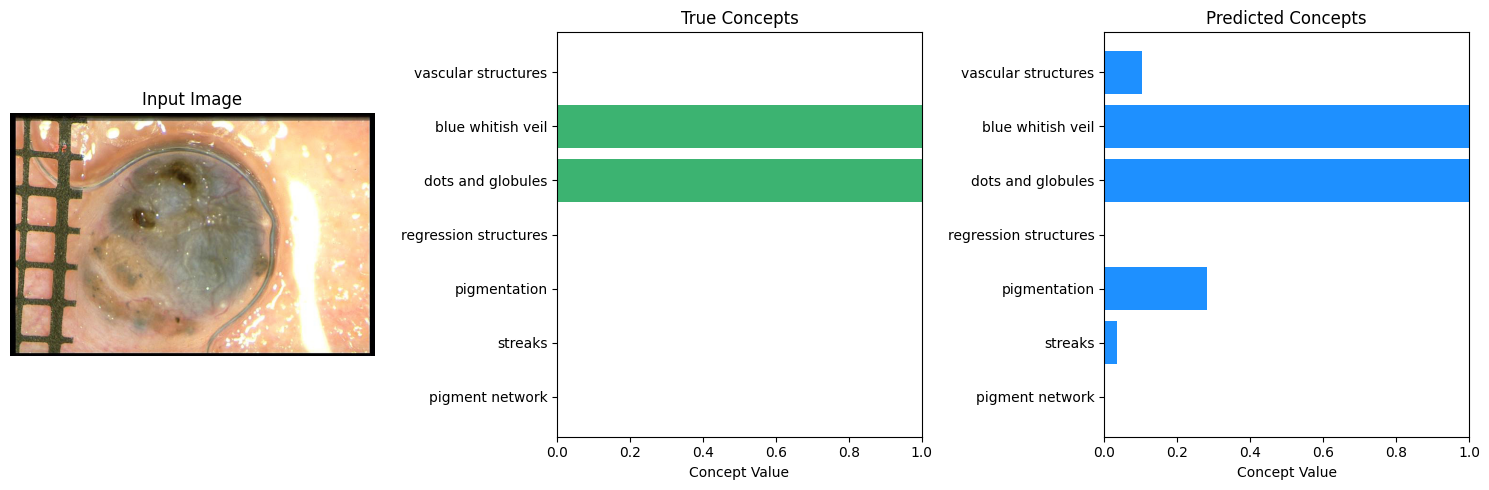

In [33]:
### Evaluation Area ###
# Visualize the concepts

index = 10 
image, true_label, true_concepts = derm7pt[index]
image = image.to(device)

# Get model predictions
with torch.no_grad():
    # to Note! this is the model from the last fold in the for loop
    predicted_concepts, predicted_label = model(image)

predicted_concepts = predicted_concepts.squeeze(0)
predicted_concepts = predicted_concepts.to('cpu')
image = image.to('cpu')


# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
concept_names = [name.replace('_num', '') for name in Derm7pt_data.model_columns['concepts']]
concept_names = [name.replace('_', ' ') for name in concept_names]
# image
ax[0].imshow(image.squeeze().permute(1, 2, 0))  # Convert image tensor to (H, W, C) format for imshow
ax[0].set_title("Input Image")
ax[0].axis('off')
# True Concepts
ax[1].barh(concept_names, true_concepts, color='mediumseagreen')
ax[1].set_title("True Concepts")
ax[1].set_xlim(0, 1)  # Assuming concepts are normalized between 0 and 1
ax[1].set_xlabel('Concept Value')
# Predicted Concepts
ax[2].barh(concept_names, predicted_concepts, color='dodgerblue')
ax[2].set_title("Predicted Concepts")
ax[2].set_xlim(0, 1)
ax[2].set_xlabel('Concept Value')
# Adjust layout to make space for titles
plt.tight_layout()

# Save the image
output_folder = 'output_Images'
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, f'concept_image_{index}.png')
plt.savefig(output_path)


plt.show()


In [19]:
# Load the dataset

def find_image_with_most_ones(indices, mode="val"):
    max_ones = 0
    max_ones_index = -1
    
    for idx in indices:
        _, _, concepts = derm7pt[idx]
        num_ones = torch.sum(concepts).item()  # Count the number of 1s in the concepts
        
        if num_ones > max_ones:
            max_ones = num_ones
            max_ones_index = idx
        
        if num_ones == 2:
            print(f"Found an image with 2 ones in concepts in {mode} set: {idx}")
    
    return max_ones_index

# Find the image with the most 1s in the concepts for both train and val sets
train_max_ones_index = find_image_with_most_ones(train_idx, "train")
val_max_ones_index = find_image_with_most_ones(val_idx)

# Print the results
print(f"Train set image index with the most 1s in concepts: {train_max_ones_index}")
print(f"Validation set image index with the most 1s in concepts: {val_max_ones_index}")


Found an image with 2 ones in concepts in train set: 9
Found an image with 2 ones in concepts in train set: 11
Found an image with 2 ones in concepts in train set: 13
Found an image with 2 ones in concepts in train set: 14
Found an image with 2 ones in concepts in train set: 16
Found an image with 2 ones in concepts in train set: 19
Found an image with 2 ones in concepts in train set: 21
Found an image with 2 ones in concepts in train set: 22
Found an image with 2 ones in concepts in train set: 25
Found an image with 2 ones in concepts in train set: 28
Found an image with 2 ones in concepts in train set: 32
Found an image with 2 ones in concepts in train set: 34
Found an image with 2 ones in concepts in train set: 37
Found an image with 2 ones in concepts in train set: 38
Found an image with 2 ones in concepts in train set: 40
Found an image with 2 ones in concepts in train set: 89
Found an image with 2 ones in concepts in train set: 99
Found an image with 2 ones in concepts in train s